# XGBoost model

In [28]:
import pandas as pd
import numpy as np
#from sklearn import cross_validation
from sklearn.model_selection import cross_validate
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['figure.figsize'] = [20.0,8.0]
plt.rcParams['figure.dpi']=80

In [49]:
#Common error function to minimize: Root Mean Square Percentage Error
#We will have to integrate our loss function with xgboost

def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w


def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe


def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

In [3]:
df = pd.read_csv("dataset/ARIMA_prep_train.csv")

In [4]:
df.shape

(409237, 50)

### Feature engineering

In [5]:
mean = df.groupby('StoreID')['NumberOfSales'].mean()
def meanSales(value):
    return mean.iloc[value-1000]

df['MeanStoreSales'] = df.StoreID.apply(meanSales)

In [6]:
mean_reg = df.groupby('Region')['NumberOfSales'].mean()

In [7]:
def mean_sales_region(value):
    return mean_reg.iloc[value]

df['MeanRegionSales'] = df.Region.apply(mean_sales_region)

In [8]:
df['D_Year'] = df['Date'].apply(lambda x: int(x[:4]))
df['D_Month'] = df['Date'].apply(lambda x: int(x[5:7]))
df['D_Day'] = df['Date'].apply(lambda x: int(x[8:10]))
#day of year missing

In [9]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Day_of_week'] = df['Date'].dt.dayofweek

In [10]:
df = df.drop(['NumberOfCustomers','IsOpen','Date','StoreID','Region','Events'], axis=1)
# I could leave events

In [11]:
df = df.drop(['AssortmentType_WithNFDept'\
             ,'AssortmentType_WithFishDept','AssortmentType_General','StoreType_SuperMarket','StoreType_HyperMarket','StoreType_StandardMarket'\
              ,'StoreType_ShoppingCenter','Is_Friday','Is_Monday','Is_Saturday','Is_Sunday','Is_Thursday','Is_Tuesday','Is_Wednesday'], axis=1)

In [12]:
df.head().T

,0,1,2,3,4
IsHoliday,0.000000,0.000000,0.000000,0.000000,0.000000
HasPromotions,1.000000,1.000000,1.000000,0.000000,1.000000
NearestCompetitor,326.000000,326.000000,326.000000,326.000000,326.000000
NumberOfSales,7109.000000,8041.000000,7890.000000,6005.000000,8550.000000
Region_AreaKM2,9643.000000,9643.000000,9643.000000,9643.000000,9643.000000
Region_GDP,17130.000000,17130.000000,17130.000000,17130.000000,17130.000000
Region_PopulationK,2770.000000,2770.000000,2770.000000,2770.000000,2770.000000
CloudCover,6.000000,6.000000,5.000000,7.000000,6.000000
Max_Humidity,100.000000,87.000000,93.000000,64.000000,59.000000
Max_TemperatureC,9.000000,5.000000,7.000000,3.000000,3.000000


In [13]:
train = df

In [14]:
#print("Load the training, test and store data using pandas")
#train = pd.read_csv("train.csv",low_memory=False)
#test = pd.read_csv("test.csv")
#store = pd.read_csv("store.csv")

### Selecting predictive features 

In [30]:
features = list(train.columns.values)
features.remove('NumberOfSales')
print("features")

print(features)

features
['IsHoliday', 'HasPromotions', 'NearestCompetitor', 'Region_AreaKM2', 'Region_GDP', 'Region_PopulationK', 'CloudCover', 'Max_Humidity', 'Max_TemperatureC', 'Max_Wind_SpeedKm_h', 'Mean_Humidity', 'Mean_TemperatureC', 'Mean_VisibilityKm', 'Mean_Wind_SpeedKm_h', 'Min_Dew_PointC', 'Min_TemperatureC', 'Precipitationmm', 'Day_of_week', 't-14', 't-7', 't-1', 't-2', 't-9', 't-8', 't-6', 't-15', 't-21', 't-13', 't-20', 'MeanStoreSales', 'MeanRegionSales', 'D_Year', 'D_Month', 'D_Day']


In [31]:
params = {"objective": "reg:linear",
          "eta": 0.2,
          "max_depth": 8,
          "subsample": 1.0,
          "colsample_bytree": 0.3,
          "silent": 1,
          "nthread":-1
          }
num_trees = 100 #400

In [33]:
X_train, X_test = train_test_split(train, test_size=0.2)
#X_train, X_test = train.head(len(train) - val_size), train.tail(val_size)

In [34]:
dtrain = xgb.DMatrix(X_train[features], np.log(X_train["NumberOfSales"] + 1))
dvalid = xgb.DMatrix(X_test[features], np.log(X_test["NumberOfSales"] + 1))
#dtest = xgb.DMatrix(test[features])

In [35]:
X_train.shape

(327389, 35)

In [36]:
X_test.shape

(81848, 35)

In [37]:
watchlist = [(dvalid, 'test'), (dtrain, 'train')]
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=20, feval=rmspe_xg, verbose_eval=True)

[0]	test-rmse:6.3372	train-rmse:6.33598	test-rmspe:0.998318	train-rmspe:0.998314
Multiple eval metrics have been passed: 'train-rmspe' will be used for early stopping.

Will train until train-rmspe hasn't improved in 20 rounds.
[1]	test-rmse:5.07244	train-rmse:5.07127	test-rmspe:0.993523	train-rmspe:0.993512
[2]	test-rmse:4.05989	train-rmse:4.05886	test-rmspe:0.982022	train-rmspe:0.981998
[3]	test-rmse:3.25069	train-rmse:3.24981	test-rmspe:0.959652	train-rmspe:0.959615
[4]	test-rmse:2.60309	train-rmse:2.60224	test-rmspe:0.923314	train-rmspe:0.923264
[5]	test-rmse:2.08575	train-rmse:2.08492	test-rmspe:0.871794	train-rmspe:0.871772
[6]	test-rmse:1.67144	train-rmse:1.67061	test-rmspe:0.807004	train-rmspe:0.807106
[7]	test-rmse:1.3416	train-rmse:1.3407	test-rmspe:0.732144	train-rmspe:0.732473
[8]	test-rmse:1.07735	train-rmse:1.07646	test-rmspe:0.652319	train-rmspe:0.653175
[9]	test-rmse:0.866699	train-rmse:0.865697	test-rmspe:0.571963	train-rmspe:0.573564
[10]	test-rmse:0.69913	train-rmse:

### Validating

In [38]:
print("Validating")
train_probs = gbm.predict(xgb.DMatrix(X_test[features]))
indices = train_probs < 0
train_probs[indices] = 0
error = rmspe(np.exp(train_probs) - 1, X_test['NumberOfSales'].values)
print('error', error)

Validating
error 0.10987917824731513


RMSE

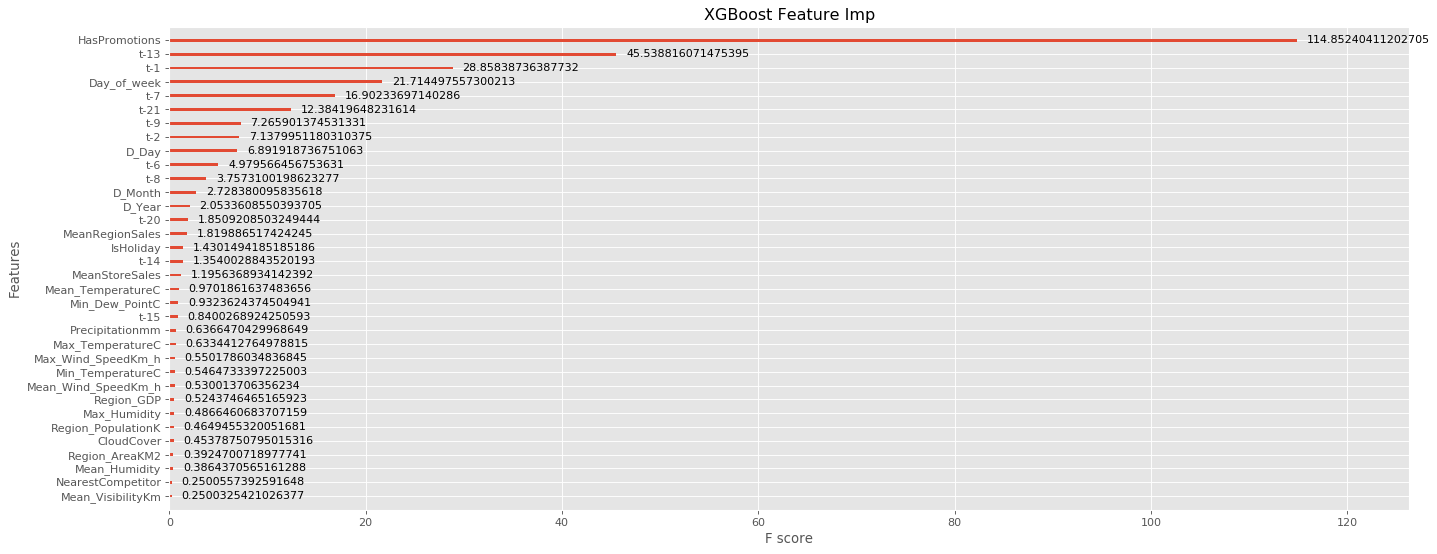

In [41]:
# # Feature importance XGB for all features 
from xgboost import plot_importance
plot_importance(gbm, importance_type="gain")
plt.title("XGBoost Feature Gain")
plt.show()

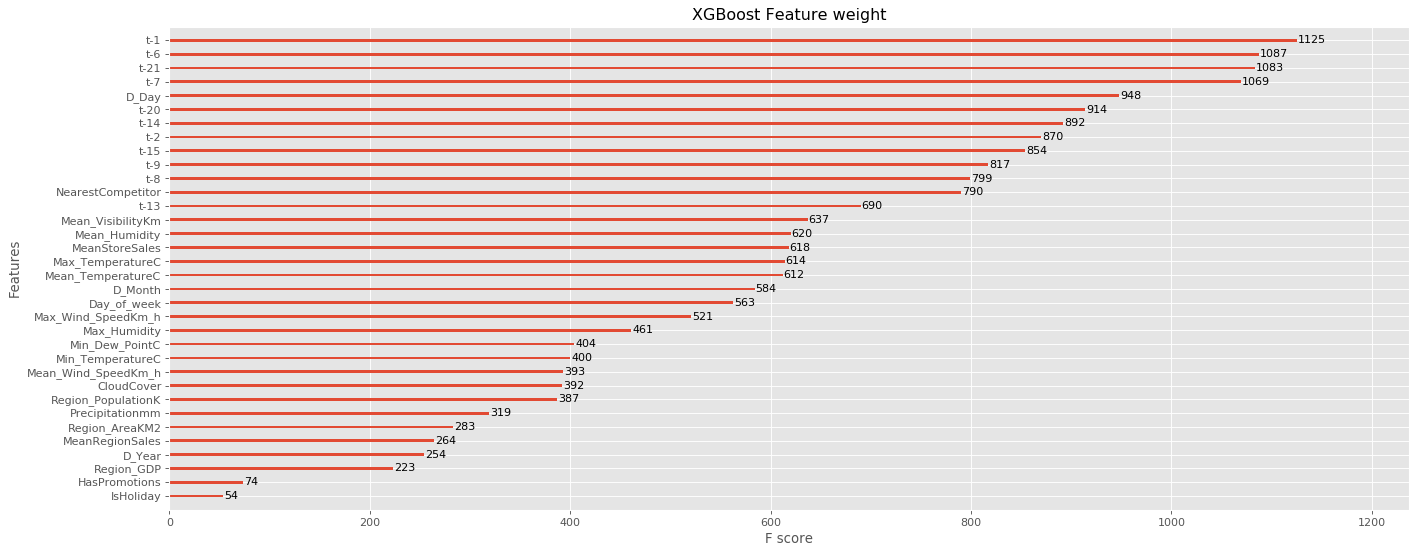

In [42]:
# # Feature importance XGB for all features 
from xgboost import plot_importance
plot_importance(gbm, importance_type="weight")
plt.title("XGBoost Feature weight")
plt.show()

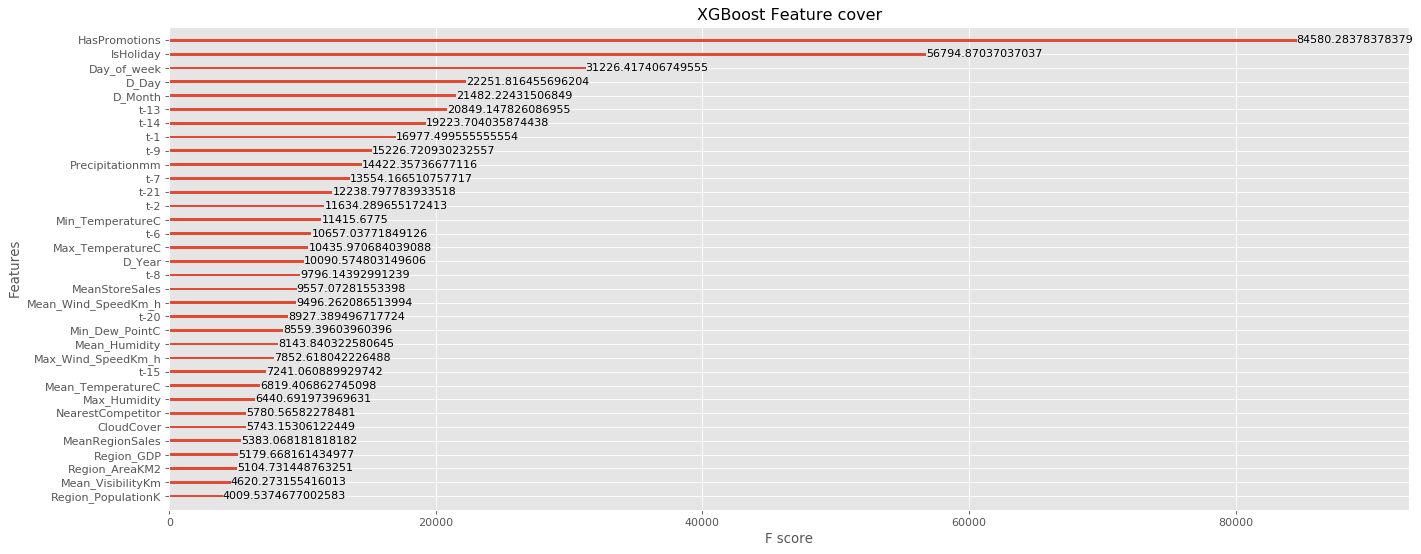

In [43]:
# # Feature importance XGB for all features 
from xgboost import plot_importance
plot_importance(gbm, importance_type="cover")
plt.title("XGBoost Feature cover")
plt.show()

### Predict on test set

In [51]:
#test = pd.read_csv("dataset/test.csv")

In [26]:
test_probs = gbm.predict(xgb.DMatrix(test[features]))
indices = test_probs < 0
test_probs[indices] = 0
submission = pd.DataFrame({"Id": test["Id"], "Sales": np.exp(test_probs) - 1})
submission.to_csv("xgboost_kscript_submission.csv", index=False)

Make predictions on the test set
